In [1]:
# Import some useful modules.
import jax
import jax.numpy as np
import os
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from '/units_constants.py' import Conversion_Factors as cf



# Import JAX-FEM specific modules.
from jax_fem.problem import Problem
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh_gmsh, get_meshio_cell_type, Mesh


       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



### Constitutive relationship
We're using SI units I have decided. 
Note to self: make unit conversion class or copy it from the 'Oumuamua code.

17/02/2025: Tested the limits of compression for sim 1. Crashed for 15%, but interestingly only once we go back up again after compressing fully to 15%. So I guess this is where the 'the cube has changed so the material responds differently now, especially to pulling'  comes into play. Rather than puling, I should unload/release. One more run with 20%, and let's see then.

And now it fails at 13%, in the compression step, for 100 iterations (in the loop). So the failing is very much a numerical thing, because why else would 15% compression work for one sim and not for another, when the only difference is step size? I did this for params1 (Y = 1, nu = 0.05, E = 100). 

19/02/2025: FOund out that stepsize matters in the PETSC_solver, and has nothing to do with $\nu$.Then found out that using jax_solver or umfpack_solver instead lets literally everything converge at 20%, for both stepsizes. So it was the solver :P, at least in part, and defo something numerical.

Also, try different solvers? So I guess the main takeaway is that the convergence issue should be looked at very carefully, and not automatically be attributed to the physics and very much also to the numerics.

## Problem class

In [2]:
class DensityError(Exception):
    pass

class Plasticity(Problem):

    def custom_init(self, dens, E_factor, nu):
        """_summary_

        Args:
            density (list, optional): the density field. Defaults to [0.0001]. Don't go over 
        """
        # ceate objects for r
        self.fe = self.fes[0]
        self.epsilons_old = np.zeros((len(self.fe.cells), self.fe.num_quads, self.fe.vec, self.dim))
        self.sigmas_old = np.zeros_like(self.epsilons_old)
        # not dens[0], but dens. Otherwise you get an array of 8 (so 1 cell) --> need to understand the use of additional args. and such properly. 
        self.density = dens 
        #print(self.density.shape)

        # these are things that can change throughout the sim
        self.internal_vars = [self.sigmas_old, self.epsilons_old, self.density]

        # elasticity coefficients
        self.E_factor = E_factor
        self.nu = nu


    def get_tensor_map(self):
        # meaning: get the tensors you want to solve for.
        # we throw away the strain and density
        _, stress_return_map = self.get_maps()
        return stress_return_map
    

    def get_maps(self):
        def safe_sqrt(x):  
            # np.sqrt is not differentiable at 0
            safe_x = np.where(x > 0., np.sqrt(x), 0.)
            return safe_x

        def safe_divide(x, y):
            return np.where(y == 0., 0., x/y)

        def strain(u_grad):
            return 0.5*(u_grad + u_grad.T)
        
        def stress(eps, E):
            return E*self.nu/((1+self.nu)*(1-2*self.nu))*np.trace(eps)*np.eye(self.dim) + 2*E/(2.*(1. + self.nu))*eps
        
        def E_calc(density):
            # question is, can I call this outside the problem?
            # no need, just set E_Factor and nu outside and then calculate again. Not efficient, but straightforward.
            return self.E_factor*density

        def P_comp(density):
            """Calculates the compressive strength of a material as a function of volume filling factor for homogeneous, monodisperse monomers. Adapted from Tatsuuma et al. 2023.
            The equation takes the density rather than volume filling factor as input. 

            Args:
                density (float, array-like): N dim. array of cell volumes

            Returns:
                float, array-like: compressive strength of each cell in the material
            """
            # C = (4*np.pi*r0**3)/(3*m0) # constant
            C = 1 # for a density varying between 0 and 1, C <= phi_max
            phi = C*density
            Y = (Eroll/(r0**3)) * (1/(C*density) - 1/phi_max)**(-3)

            return Y

        def stress_return_map(u_grad, sigma_old, eps_old, density):
            """ Calculate the new stress field from the old deformation gradient, old stress, and old strain. 

            Args:
                u_grad (_type_): 3x3 matrix, gradient of the solution
                sigma_old (_type_): 3x3 matrix of the stresses
                eps_old (_type_): 3x3 matrix of the strains
                density (_type_): scalar value of the density

            Returns:
                _type_: updated stress

            """
    
            # calculate the yield strength and Young's modulus from the density field
            Y = P_comp(density)
            E = E_calc(density) # E = constant * density
            
            # calculate the new stress field with a radial return map
            deps = strain(u_grad) - eps_old
            sigma_trial = stress(deps, E) + sigma_old
            s_dev = sigma_trial - 1./self.dim*np.trace(sigma_trial)*np.eye(self.dim)
            von_Mises = safe_sqrt(3./2.*np.sum(s_dev*s_dev))
            f_yield = von_Mises - Y
            f_yield_plus = np.where(f_yield > 0., f_yield, 0.)
            sigma = sigma_trial - safe_divide(f_yield_plus*s_dev,von_Mises)

            return sigma
        
        return strain, stress_return_map
    
    def stress_strain_funcs(self):
        """Return mapping functions for stress, strain, density

        Returns:
            _type_: _description_
        """
        strain, stress_return_map = self.get_maps()
        vmap_strain = jax.vmap(jax.vmap(strain))
        vmap_stress_return_map = jax.vmap(jax.vmap(stress_return_map))
        return vmap_strain, vmap_stress_return_map
        

    def update_stress_strain_density(self, sol, density):
        # set new values for old stress, strain, density
        u_grads = self.fe.sol_to_grad(sol)
        vmap_strain, vmap_stress_rm = self.stress_strain_funcs()
        self.density = density
        self.sigmas_old = vmap_stress_rm(u_grads, self.sigmas_old, self.epsilons_old, self.density) # use old or new density? I think old
        self.epsilons_old = vmap_strain(u_grads)
        self.internal_vars = [self.sigmas_old, self.epsilons_old, self.density]
        print(self.density.shape, self.sigmas_old.shape, self.epsilons_old.shape)


    def compute_avg_stress(self):
        # For post-processing only: Compute volume averaged stress.
        # (num_cells*num_quads, vec, dim) * (num_cells*num_quads, 1, 1) -> (vec, dim)
        sigma = np.sum(self.sigmas_old.reshape(-1, self.fe.vec, self.dim) * self.fe.JxW.reshape(-1)[:, None, None], 0)
        vol = np.sum(self.fe.JxW)
        avg_sigma = sigma/vol
        return avg_sigma


### Simulation

In [ ]:
# grain/aggregate params
# change 0 to s for solid or silicate
xi_crit = 8*1e-10 # critical rolling energy, 8 angstrom in m
rho_0 = 2.65 * 1e3 / 1e6 # silicate, g/cm^3 in kg/m^3
r0 = 0.1e-6 # monomer size, 0.1 micron in m
gamma = 20*1e3 # surface energy, mJ/m^2 in J/m^2
m0 = rho_0 * (4*np.pi)/3 * r0**3 # monomer mass in kg, silicate 
Eroll = 6*np.pi**2 * gamma * r0 * xi_crit # rolling energy 
phi_max = 0.78 # max volume filling factor

# material params
E_factor = 1.
nu = 0.05
rho_center = 0.001

# file path and name 
test_num = 'field' 
solver_type = 'jax_solver'
Nx, Ny, Nz = 10, 10, 10 # cells in a row
N_cells = Nx*Ny*Nz
steps = 20
deform = 0.8
dens = rho_center
perc = '80' # deformation percentage
E_val = f'{str(E_factor)}rho' # make this into an actual modifiable param
data_dir = os.path.join(os.path.dirname('/home/elouan/Compression/'), f'density-model-{test_num}_{perc}_{solver_type}_{dens}_{E_val}')

# mesh generation
ele_type = 'HEX8' # first-order hexahedron element
cell_type = get_meshio_cell_type(ele_type)
Lx, Ly, Lz = 1., 1., 1.
meshio_mesh = box_mesh_gmsh(Nx=Nx, Ny=Ny, Nz=Nz, Lx=Lx, Ly=Ly, Lz=Lz, data_dir=data_dir, ele_type=ele_type)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])



# Find node coordinates located at the boundaries
def top(point):
    return np.isclose(point[2], Lz, atol=1e-5)

def bottom(point):
    return np.isclose(point[2], 0., atol=1e-5)

def center_x(point):
    return np.isclose(point[0], Lx/2, atol = 1e-2)

def center_y(point):
    return np.isclose(point[1], Ly/2, atol = 1e-2)


# Define Dirichlet boundary values.
# We fix the z-component of the displacement field to be zero on the 'bottom' side and control the z-component on the 'top' side.
def dirichlet_val_bottom(point):
    return 0.

def get_dirichlet_top(disp):
    def val_fn(point):
        return disp
    return val_fn

def set_density(mesh, rho_center):
    """Generates a spherical density field with 1/r dependence for a mesh object. Normalised to rho_hi, the desired density in the center
    of the material.

    Args:
        problem (_type_): _description_

    Returns:
        float, tracer array-like: array of shape ((1000, 8)) with the initial density field
    """
    node_coords_cells = mesh.points[mesh.cells]
    cell_centers = np.mean(node_coords_cells, axis=1)
    material_center = np.mean(node_coords_cells)
    rvec = cell_centers-material_center

    # get norm of distance
    r = np.linalg.norm(rvec, axis = 1)

    # spherical density field
    rho_scaling_factor = 1/r
    max_rho_factor = np.max(rho_scaling_factor)
    cell_density = (rho_center/max_rho_factor) * rho_scaling_factor
    node_density = np.repeat(cell_density, 8).reshape((-1, 8))

    return node_density
    
def soundspeed(density):
    """Calculates the soundspeed for a 3D solid at each node in m/s as a function of density.

    Args:
        density (_type_): _description_

    Returns:
        _type_: _description_
    """
    E = E_factor*density # E = constant * density
    csp = np.sqrt((E*(1-nu)/(density*(1-2*nu)))) # soundspeed in a 3D solid

    return csp

# Set Dirichlet conditions
disps = np.linspace(0.,-deform,steps) # compression in the z-dir
location_fns = [center_x, center_y, bottom, top]
value_fns = [dirichlet_val_bottom]*3 + [get_dirichlet_top(disps[0])]
vecs = [0, 1, 2, 2]

dirichlet_bc_info = [location_fns, vecs, value_fns]


# Set density field
# this is so bad and prone to errors! But I need it for now to handle the cell volume being < 1.
density_init = set_density(mesh, rho_center)/(Nx * Ny * Nz)
args = [density_init, E_factor, nu]

# Initialise problem
problem = Plasticity(mesh, vec=3, dim=3, dirichlet_bc_info=dirichlet_bc_info, additional_info=args)
avg_stresses = []
cell_vols = []
mat_vol = []
csps = []


# Solve the problem
for i, disp in enumerate(disps):
    print(f"\nStep {i} in {len(disps)}, disp = {disp}")

    # update boundary conditions and density field
    dirichlet_bc_info[-1][-1] = get_dirichlet_top(disp)
    problem.fe.update_Dirichlet_boundary_conditions(dirichlet_bc_info)

    # solve problem
    sol_list = solver(problem, solver_options={f'{solver_type}': {}})
    
    # calculate soundspeed with new density
    csp = soundspeed(problem.density)
    csps.append(csp)

    # save data: deformation, mean cell density and mean cell soundspeed
    vtk_path = os.path.join(data_dir, f'vtk/sol_{i:03d}.vtu')
    cell_mean_densities = np.mean(problem.density, axis=1)
    cell_mean_soundspeed = np.mean(csp, axis = 1)
    save_sol(problem.fe, sol_list[0], vtk_path, cell_infos = [['density',cell_mean_densities], ['sound speed', cell_mean_soundspeed]])
    

    # retrieve coordinates of the nodes grouped per cell
    coords_cell_nodes = problem.fe.points[problem.fe.cells] + sol_list[0][problem.fe.cells]

    # compute cell volumes with ConvexHull
    cell_volume = np.zeros(N_cells)
    for i in range(N_cells):
        points = coords_cell_nodes[i]
        hull = ConvexHull(points)
        # cell volumes in this iteration
        cell_volume = cell_volume.at[i].set(hull.volume) # simple item assignement doesn't work with jax aparently, hence this code line instead

    # save volumes for each iteration to a list
    cell_vols.append(cell_volume)
    mat_vol = np.sum(cell_volume)

    # uniform density
    # density = np.repeat(density_init[0]*(1/cell_volume), 8).reshape((-1, 8))
    
    # calculate new density field
    cell_volume = np.repeat(cell_volume, 8).reshape((-1, 8))
    new_density = density_init*(1/cell_volume)
    # print(cell_volume.shape)
    # print(new_density.shape)
    # print(new_density[0], new_density[970])

    # update the stress, strain and density with the solution
    problem.update_stress_strain_density(sol_list[0], new_density)
    avg_stress = problem.compute_avg_stress()
    avg_stresses.append(avg_stress)

    
avg_stresses = np.array(avg_stresses)


# Plot the volume-averaged stress versus the vertical displacement of the top surface.
fig = plt.figure(figsize=(10, 8))
plt.plot(disps, avg_stresses[:, 2, 2], color='red', marker='o', markersize=8, linestyle='-') 
plt.xlabel(r'Displacement of top surface [m]', fontsize=20)
plt.ylabel(r'Volume averaged stress (z-z) [Pa]', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig(f"./density-model-{test_num}_{perc}_{solver_type}_{dens}_{E_val}/stress-strain-{test_num}.png")
plt.show()




[03-07 18:42:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[03-07 18:42:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[03-07 18:42:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[03-07 18:42:35][DEBUG] jax_fem: Done pre-computations, took 0.059686899185180664 [s]
[03-07 18:42:35][INFO] jax_fem: Solving a problem with 1000 cells, 1331x3 = 3993 dofs.
[03-07 18:42:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:42:35][DEBUG] jax_fem: Start timing
[03-07 18:42:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Extruded)
Info    : [ 10%] Meshing curve 2 (Extruded)
Info    : [ 20%] Meshing curve 3 (Extruded)
Info    : [ 30%] Meshing curve 4 (Extruded)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 50%] Meshing curve 8 (Extruded)
Info    : [ 50%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 70%] Meshing curve 12 (Extruded)
Info    : [ 80%] Meshing curve 13 (Extruded)
Info    : [ 90%] Meshing curve 17 (Extruded)
Info    : [100%] Meshing curve 21 (Extruded)
Info    : Done meshing 1D (Wall 0.000194119s, CPU 0.000184s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 20%] Meshing surface 14 (Extruded)
Info    : [ 40%] Meshing surface 18 (Extruded)
Info    : [ 50%] Meshing surface 22 (Extruded)
Info    : [ 70%] Meshing surface 26 (Extruded)
Info    : [ 90%] Meshing surface 27 (Extruded)
Info    : Done meshing 2D (Wall 0.00712395s, CPU 0.008692s)
Info    : Meshing

[03-07 18:42:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.4410 seconds
[03-07 18:42:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:42:36][DEBUG] jax_fem: Before, l_2 res = 0.0, relative l_2 res = nan
[03-07 18:42:36][INFO] jax_fem: Solve took 0.5286388397216797 [s]
[03-07 18:42:36][DEBUG] jax_fem: max of dofs = 0.0
[03-07 18:42:36][DEBUG] jax_fem: min of dofs = 0.0


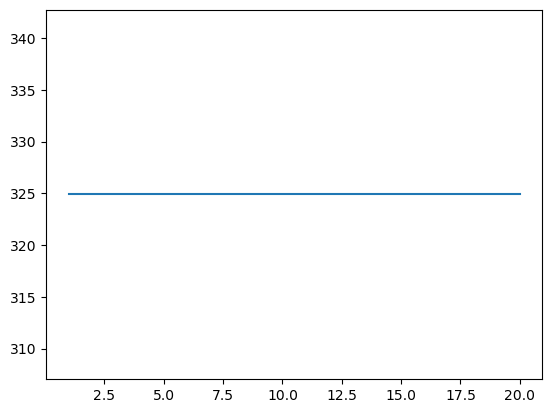

In [33]:
csps = np.array(csps)
csps[:,0,0]

plt.plot(np.arange(1,21), csps[:,970,0])


## Misc. and old code
Why do the volumes stay the same throughout the deformation? Checked cell coordinates of the first cell, and they don't change --> the mesh doesn't warp thoughout the sim.

Update: it works! I have the densities now :3

In [ ]:
# # 1/r density field
# """ why should density be defined on each node? (each cell has it's own set of nodes, they don't share them) """
# foo_dens = np.zeros((len(problem.fe.cells), problem.fe.num_quads))
# print(foo_dens.shape)
# coords_cell_nodes = problem.fe.points[problem.fe.cells]

# # THIS DETERMINES THE DENSITY BASED ON The cell center
# cell_centers=np.mean(coords_cell_nodes,axis=1)
# material_center=np.mean(coords_cell_nodes)
# rvec=cell_centers-material_center


# #jax.vmap(np.linalg.norm)(rvec)
# r=np.linalg.norm(rvec,axis=1)

# # spherical density field which drops of as 1/r
# density_init=1/r

# # Uniform density field
# rho_lo = 0.0001
# rho_hi = 0.01

# density_uni = [rho_lo* 1/(Nx * Ny * Nz), rho_hi * 1/(Nx * Ny * Nz)] # the extra factor is so that this will be the actual density, not the density x a factor from the grid size
# density_uni_init = [rho_lo* 1/(Nx * Ny * Nz), rho_hi* 1/(Nx * Ny * Nz)] 
# args = [density_uni_init]

# # Cell volumes
# coords_cell_nodes = problem.fe.points[problem.fe.cells]

# cell_vols = np.zeros(N_cells)
# for i in range(N_cells):
#     points = coords_cell_nodes[i]
#     hull = ConvexHull(points)
#     cell_vols = cell_vols.at[i].set(hull.volume) # simple item assignement doesn't work with jax aparently, hence this code line instead